## 1. 환경 설정 및 기본 라이브러리 설치

In [1]:
# 1. 라이브러리 설치 및 임포트
!pip install -q diffusers==0.31 controlnet-aux==0.0.1 ipywidgets>=7.0.0

import os
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
import gc
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so
/opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so...


/opt/conda/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('tcp'), Posix

In [2]:
# 2. GPU 메모리 최적화 및 전처리 함수 정의
torch.cuda.empty_cache()
gc.collect()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:32'
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

def process_canny(image, low_threshold=100, high_threshold=200):
    """Canny 윤곽선 검출을 수행해 3채널 이미지로 반환"""
    img_np = np.array(image)
    edges = cv2.Canny(img_np, low_threshold, high_threshold)
    edges = np.stack([edges] * 3, axis=-1)
    return Image.fromarray(edges)

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50896 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 50896 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 48376 missing from current font.
  font.set_text(s, 0, flags=flags)


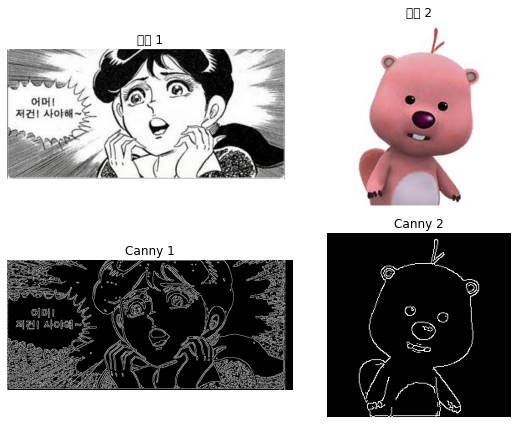

In [3]:
# 3. 입력 이미지 로드 및 전처리
# - must_buy.jpg: 소녀의 놀라는 표정 이미지
# - loopy.jpeg: 뽀로로 캐릭터 루피 이미지
base_dir = "/aiffel/aiffel/art_studio_outputs"
filenames = ["must_buy.jpg", "loopy.jpeg"]
originals, edges = [], []
for name in filenames:
    path = os.path.join(base_dir, name)
    if not os.path.exists(path):
        raise FileNotFoundError(f"파일을 찾을 수 없습니다: {path}")
    img = Image.open(path).convert("RGB")
    originals.append(img)
    edges.append(process_canny(img))

# 원본 및 전처리 결과 시각화
plt.figure(figsize=(8, 6))
for i, (o, e) in enumerate(zip(originals, edges), 1):
    plt.subplot(2, 2, i)
    plt.imshow(o); plt.title(f"원본 {i}"); plt.axis('off')
    plt.subplot(2, 2, i+2)
    plt.imshow(e); plt.title(f"Canny {i}"); plt.axis('off')
plt.tight_layout(); plt.show()

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54633 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 46108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50980 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44285 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49440 missing from current font.
  font.set_

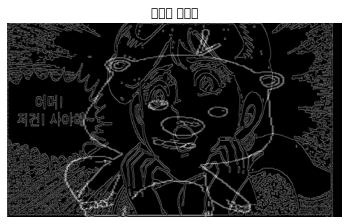

In [4]:
# 4. 두 이미지 윤곽선 특징 결합 (크기 평균화 && 리사이징)
# 각 윤곽선 이미지 크기 계산
sizes = [e.size for e in edges]  # (width, height)
avg_w = int(np.mean([w for w, h in sizes]))
avg_h = int(np.mean([h for w, h in sizes]))
# 리사이즈 후 numpy 변환
resized_arrs = []
for e in edges:
    e_resized = e.resize((avg_w, avg_h))
    resized_arrs.append(np.array(e_resized, dtype=np.float32))
# 평균 결합
combined_arr = np.mean(resized_arrs, axis=0)
combined_img = Image.fromarray(np.clip(combined_arr, 0, 255).astype(np.uint8))

plt.figure(figsize=(6,6))
plt.imshow(combined_img); plt.title("결합된 윤곽선"); plt.axis('off')
plt.show()

In [9]:
# 5. ControlNet 파이프라인 설정 및 프롬프트 정의
def setup_pipeline(controlnet_model_path):
    controlnet = ControlNetModel.from_pretrained(
        controlnet_model_path,
        torch_dtype=torch.float16
    )
    pipe = StableDiffusionControlNetPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        controlnet=controlnet,
        torch_dtype=torch.float16,
        low_cpu_mem_usage=True,
        safety_checker=None
    )
    pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
    return pipe.to("cuda")

pipe = setup_pipeline("lllyasviel/sd-controlnet-canny")
prompt = (
    "cute, wide-eyed surprise expression, cartoon style, colorful, "
)
negative_prompt = "blurry, low quality, deformed, dull colors"
generator = torch.manual_seed(1234)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

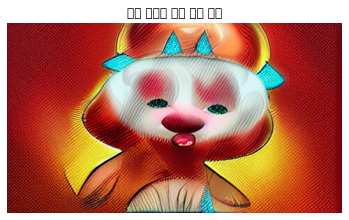

최종 생성된 이미지 저장 완료: /aiffel/aiffel/art_studio_outputs/surprised_loopy_final.png


In [19]:
# 6. 이미지 생성 및 저장
result_img = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=combined_img,
    num_inference_steps=50,
    guidance_scale=5,
    generator=generator
).images[0]

plt.figure(figsize=(6,6))
plt.imshow(result_img); plt.title("깜짝 놀라는 루피 생성 결과"); plt.axis('off')
plt.show()

output_path = os.path.join(base_dir, "surprised_loopy_final.png")
result_img.save(output_path)
print(f"최종 생성된 이미지 저장 완료: {output_path}")